# Mapping Fathom flood data

The Fathom flood data are stored on an AWS bucket as tiles in virtual rasters. This code extracts values for specific scenarios, for a specific country, and plots them.

In [22]:
import sys
import os
import boto3
import rasterio

import pandas as pd
import geopandas as gpd

sys.path.insert(0, "../../src")

import GOSTrocks.mapMisc as mapMisc
import GOSTrocks.dataMisc as dMisc
import GOSTrocks.rasterMisc as rMisc
from GOSTrocks.misc import tPrint

In [8]:
iso3 = "KEN"
out_folder = f"/home/wb411133/temp/FATHOM/{iso3}"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    
# This demo uses the default national boundaries included with GeoPandas, but this can be changed here
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
inB = world.loc[world['iso_a3'] == iso3].copy()

In [9]:
# Select layer to downlaod
flood_type = ["COASTAL","FLUVIAL","PLUVIAL"]
defence = ["DEFENDED"]
return_period = ['1in50']
climate_model = ["PERCENTILE50"]
year = ["2020"]

# all_vrts is a pandas dataframe with all the vrt paths to the global datasets, with columns defining
# the various models' defining attributes
all_vrts = dMisc.get_fathom_vrts(True)
sel_images = all_vrts.loc[(all_vrts['FLOOD_TYPE'].isin(flood_type)) & (all_vrts['DEFENCE'].isin(defence)) & 
             (all_vrts['RETURN'].isin(return_period))  & (all_vrts['CLIMATE_MODEL'].isin(climate_model))]

In [10]:
sel_images

,RETURN,FLOOD_TYPE,DEFENCE,DEPTH,YEAR,CLIMATE_MODEL,PATH
390,1in50,COASTAL,DEFENDED,DEPTH,2020,PERCENTILE50,s3://wbg-geography01/FATHOM/GLOBAL-1ARCSEC-NW_...
416,1in50,FLUVIAL,DEFENDED,DEPTH,2020,PERCENTILE50,s3://wbg-geography01/FATHOM/GLOBAL-1ARCSEC-NW_...
442,1in50,PLUVIAL,DEFENDED,DEPTH,2020,PERCENTILE50,s3://wbg-geography01/FATHOM/GLOBAL-1ARCSEC-NW_...


In [23]:
flood_data = {}
for idx, row in sel_images.iterrows():
    fluvialR = rasterio.open(row['PATH'])
    rData, profile = rMisc.clipRaster(fluvialR, inB)
    flood_data[row['FLOOD_TYPE']] = [rData, profile]
    tPrint(row['PATH'])
    

08:44:55	s3://wbg-geography01/FATHOM/GLOBAL-1ARCSEC-NW_OFFSET-1in50-COASTAL-DEFENDED-DEPTH-2020-PERCENTILE50-v3.0.vrt
08:46:01	s3://wbg-geography01/FATHOM/GLOBAL-1ARCSEC-NW_OFFSET-1in50-FLUVIAL-DEFENDED-DEPTH-2020-PERCENTILE50-v3.0.vrt
08:47:12	s3://wbg-geography01/FATHOM/GLOBAL-1ARCSEC-NW_OFFSET-1in50-PLUVIAL-DEFENDED-DEPTH-2020-PERCENTILE50-v3.0.vrt


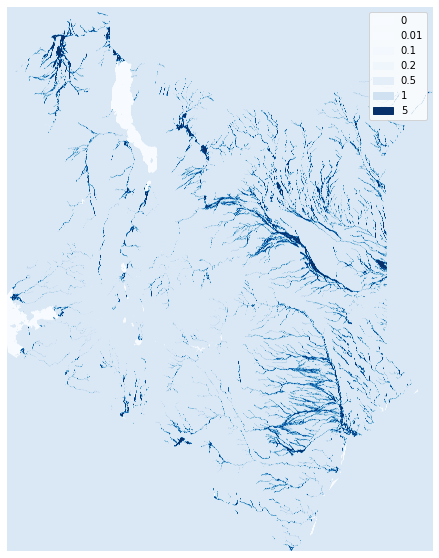

In [24]:
rData, profile = flood_data['FLUVIAL']
with rMisc.create_rasterio_inmemory(profile, rData) as floodR:
    mapMisc.static_map_raster(
        floodR, colormap="Blues", thresh=[0, 0.01, 0.1, 0.2, 0.5, 1, 5]
    )

In [ ]:
rData, profile = flood_data['PLUVIAL']
with rMisc.create_rasterio_inmemory(profile, rData) as floodR:
    mapMisc.static_map_raster(
        floodR, colormap="Blues", thresh=[0, 0.01, 0.1, 0.2, 0.5, 1, 5]
    )

In [ ]:
rData, profile = flood_data['COASTAL']
with rMisc.create_rasterio_inmemory(profile, rData) as floodR:
    mapMisc.static_map_raster(
        floodR, colormap="Blues", thresh=[0, 0.01, 0.1, 0.2, 0.5, 1, 5]
    )

In [16]:
rMisc.create_rasterio_inmemory?